In [50]:
pip install cgal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 3.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
from CGAL.CGAL_Kernel import Point_2
from CGAL.CGAL_Triangulation_2 import Delaunay_triangulation_2
import gudhi as gd
import matplotlib.pyplot as plt
import time
import gc
import numpy as np
from joblib import Parallel, delayed
from CGAL.CGAL_Alpha_shape_2 import Alpha_shape_2

In [196]:
dt = Delaunay_triangulation_2()

initial_points = [Point_2(0, 0), Point_2(1, 0), Point_2(0, 1)]
for point in initial_points:
    dt.insert(point)
    
print("Initial triangulation:")
print("Number of vertices:", dt.number_of_vertices())
for face in dt.finite_faces():
    # 獲取三角形的三個頂點
    vertices = [face.vertex(i) for i in range(3)]
    print("Triangle:", [(v.point().x(), v.point().y()) for v in vertices])

Initial triangulation:
Number of vertices: 3
Triangle: [(0.0, 0.0), (1.0, 0.0), (0.0, 1.0)]


In [197]:
new_point = Point_2(0.5, 0.5)
vh = dt.insert(new_point)

print("\nUpdated triangulation after adding new point (0.5, 0.5):")
print("Number of vertices:", dt.number_of_vertices())
for face in dt.finite_faces():
    vertices = [face.vertex(i) for i in range(3)]
    print("Triangle:", [(v.point().x(), v.point().y()) for v in vertices])
    
dt.remove(vh)

print("\nUpdated triangulation after adding new point (0.5, 0.5):")
print("Number of vertices:", dt.number_of_vertices())
for face in dt.finite_faces():
    vertices = [face.vertex(i) for i in range(3)]
    print("Triangle:", [(v.point().x(), v.point().y()) for v in vertices])


Updated triangulation after adding new point (0.5, 0.5):
Number of vertices: 4
Triangle: [(0.0, 0.0), (1.0, 0.0), (0.5, 0.5)]
Triangle: [(0.0, 0.0), (0.5, 0.5), (0.0, 1.0)]

Updated triangulation after adding new point (0.5, 0.5):
Number of vertices: 3
Triangle: [(0.0, 0.0), (1.0, 0.0), (0.0, 1.0)]


In [10]:
from CGAL.CGAL_Kernel import Point_2
from CGAL.CGAL_Triangulation_2 import Delaunay_triangulation_2
from CGAL.CGAL_Alpha_shape_2 import Alpha_shape_2, GENERAL
import gudhi as gd
import matplotlib.pyplot as plt

class IncrementalAlphaComplex:
    def __init__(self, alpha=0.1):
        self.alpha_value = alpha
        self.points = []  # 保存所有的點
        self.dt = Delaunay_triangulation_2()
        self.simplex_tree = gd.SimplexTree()
        self.alpha_shape = None
        self.barcode_values = []  # 保存持久條形碼的增量更新

    def init_alpha_complex(self):
        """初始化 alpha complex"""
        self.alpha_shape = Alpha_shape_2(self.points, self.alpha_value, GENERAL)
        self.simplex_tree = gd.SimplexTree()
        self._add_alpha_shape_edges_and_faces()

    def _get_point_index(self, vertex_handle):
        """返回 vertex_handle 對應的索引"""
        vertex_point = vertex_handle.point()
        for i, point in enumerate(self.points):
            if point.x() == vertex_point.x() and point.y() == vertex_point.y():
                return i
        return None

    def _add_alpha_shape_edges_and_faces(self):
        """將 alpha shape 中的邊和面插入到 SimplexTree 中"""
        inserted_edges = set()
        inserted_faces = set()

        for edge in self.alpha_shape.alpha_shape_edges():
            try:
                v0, v1 = edge[0].vertex(0), edge[0].vertex(1)
                idx0 = self._get_point_index(v0)
                idx1 = self._get_point_index(v1)
                if idx0 is not None and idx1 is not None:
                    edge_tuple = tuple(sorted([idx0, idx1]))
                    if edge_tuple not in inserted_edges:
                        self.simplex_tree.insert([idx0, idx1])
                        inserted_edges.add(edge_tuple)
            except Exception as e:
                print("Error inserting edge:", e)

        for face in self.alpha_shape.finite_faces():
            try:
                v0, v1, v2 = face.vertex(0), face.vertex(1), face.vertex(2)
                idx0 = self._get_point_index(v0)
                idx1 = self._get_point_index(v1)
                idx2 = self._get_point_index(v2)
                if None not in (idx0, idx1, idx2):
                    face_tuple = tuple(sorted([idx0, idx1, idx2]))
                    if face_tuple not in inserted_faces:
                        self.simplex_tree.insert([idx0, idx1, idx2])
                        inserted_faces.add(face_tuple)
            except Exception as e:
                print("Error inserting face:", e)

    def add_point(self, x, y):
        """增量插入新點並局部更新 alpha complex 和條形碼"""
        new_point = Point_2(x, y)
        self.dt.insert(new_point)
        self.points.append(new_point)

        # 更新 alpha_shape 並插入新邊和新面
        self.alpha_shape = Alpha_shape_2(self.points, self.alpha_value, GENERAL)
        self._add_alpha_shape_edges_and_faces()
        # 增量計算持久條形碼
        self.update_barcode()

    def remove_point(self, x, y):
        """增量刪除點並局部更新 alpha complex 和條形碼"""
        point_to_remove = self.dt.nearest_vertex(Point_2(x, y))
        if point_to_remove:
            self.dt.remove(point_to_remove)
            self.points.remove(point_to_remove.point())

            # 更新 alpha_shape 並插入受影響的邊和面
            self.alpha_shape = Alpha_shape_2(self.points, self.alpha_value, GENERAL)
            self._add_alpha_shape_edges_and_faces()
            # 增量計算持久條形碼
            self.update_barcode()

    def update_barcode(self):
        """增量更新條形碼"""
        self.simplex_tree.compute_persistence()
        barcode = self.simplex_tree.persistence()
        self.barcode_values = [
            (homology, birth, death)
            for homology, (birth, death) in barcode
            if death - birth > 0  # 只包含持久的特徵
        ]
        for homology, birth, death in self.barcode_values:
            print(f"H{homology}: 出生時間 = {birth}, 死亡時間 = {death}")

    def plot_barcode(self):
        """視覺化持久條形碼"""
        # 重新格式化條形碼數據以符合 gudhi 的 plot_persistence_barcode 格式
        barcode_formatted = [(homology, (birth, death)) for homology, birth, death in self.barcode_values]
        gd.plot_persistence_barcode(barcode_formatted)
        plt.show()

H0: 出生時間 = 0.0, 死亡時間 = inf
H0: 出生時間 = 0.0, 死亡時間 = inf
H0: 出生時間 = 0.0, 死亡時間 = inf
Initial persistent barcode:
H0: 出生時間 = 0.0, 死亡時間 = inf


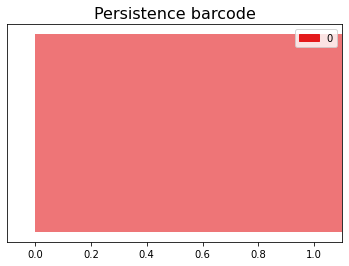


After adding a new point (5, 5):
H0: 出生時間 = 0.0, 死亡時間 = inf
H0: 出生時間 = 0.0, 死亡時間 = inf


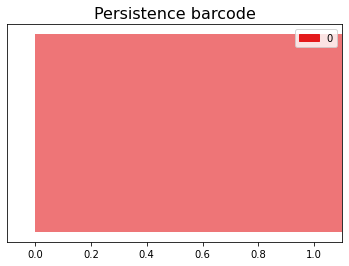


After removing a point (1, 1):
H0: 出生時間 = 0.0, 死亡時間 = inf
H0: 出生時間 = 0.0, 死亡時間 = inf


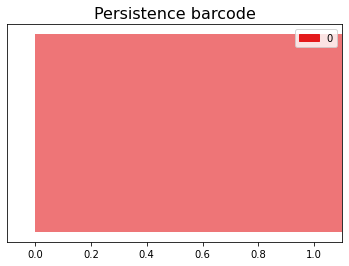

In [11]:
# 創建 IncrementalAlphaComplex 物件，並設置 alpha 參數
alpha_complex = IncrementalAlphaComplex(alpha=0.5)

# 增量插入點
alpha_complex.add_point(1, 1)
alpha_complex.add_point(2, 2)
alpha_complex.add_point(4, 4)
alpha_complex.add_point(1, 4)
alpha_complex.add_point(3, 1)
alpha_complex.add_point(3, 3)

# 觀察初始持久條形碼
print("Initial persistent barcode:")
alpha_complex.update_barcode()
alpha_complex.plot_barcode()

# 增量插入新點，並觀察持久條形碼的變化
print("\nAfter adding a new point (5, 5):")
alpha_complex.add_point(5, 5)
alpha_complex.update_barcode()
alpha_complex.plot_barcode()

# 增量刪除點，並觀察持久條形碼的變化
print("\nAfter removing a point (1, 1):")
alpha_complex.remove_point(1, 1)
alpha_complex.update_barcode()
alpha_complex.plot_barcode()

In [13]:
def update_alpha_complex(triangulation, alpha_value, new_points=[], removed_points=[]):
    # 插入新點
    for point in new_points:
        triangulation.insert(point)
    
    # 移除指定的點
    for point in removed_points:
        triangulation.remove(point)

    # 更新 α-complex
    updated_alpha_complex = []
    for simplex in triangulation.finite_cells():
        if simplex.circumradius() <= alpha_value:
            updated_alpha_complex.append(simplex)
    
    return updated_alpha_complex

In [26]:
print("Number of vertices:", triangulation.number_of_vertices())
for vertex in triangulation.finite_vertices():
    print(vertex.point())

Number of vertices: 4
1 56 2 334
1 3 1 3
1 1 1 34
1 1 33 4


In [ ]:
import math
from CGAL.CGAL_Kernel import Point_3, Weighted_point_3
from CGAL.CGAL_Triangulation_3 import Regular_triangulation_3

In [43]:
# 計算四面體的外接球半徑
def calculate_circumradius(cell):
    vertices = [cell.vertex(i).point() for i in range(4)]
    max_distance = 0
    for i in range(3):
        for j in range(i + 1, 4):
            # 歐式
            distance = math.sqrt(
                (vertices[i].x() - vertices[j].x()) ** 2 +
                (vertices[i].y() - vertices[j].y()) ** 2 +
                (vertices[i].z() - vertices[j].z()) ** 2
            )
            max_distance = max(max_distance, distance)
    return max_distance / 2 # 球半徑

# alpha complex from alpha value
def update_alpha_complex(triangulation, alpha_value, new_points=[], removed_points=[]):
    # local update
    for point in new_points:
        triangulation.insert(point)
    for point in removed_points:
        triangulation.remove(point)

    # update alpha complex
    updated_alpha_complex = []
    for cell in triangulation.finite_cells():
        if calculate_circumradius(cell) <= alpha_value:
            updated_alpha_complex.append(cell)
    
    return updated_alpha_complex

In [58]:
# 創建三角剖分物件
triangulation = Regular_triangulation_3()

# 插入點集 (包括權重)
points = [
    Weighted_point_3(Point_3(1, 1, 1), 1),
    Weighted_point_3(Point_3(1, 56, 2), 1),
    Weighted_point_3(Point_3(1, 3, 1), 1),
    Weighted_point_3(Point_3(1, 1, 33), 1),
    Weighted_point_3(Point_3(10, 10, 10), 1),
    Weighted_point_3(Point_3(20, 5, 15), 1),
]

triangulation.insert(points)


persistent_pairs = [] 
feature_births = {}  # alpha value
previous_features = set()

alpha_steps = [0.1, 1.0, 5.0, 10.0, 15.0, 20, 25, 30, 35, 40, 45, 50]
for alpha in alpha_steps:
    alpha_complex = update_alpha_complex(triangulation, alpha)
    current_features = set(alpha_complex)  # 將當前 α 值的特徵存入集合

    # check new birth feature
    new_features = current_features - previous_features
    for feature in new_features:
        feature_births[feature] = alpha  # 新特徵的出生 α 值

    # check death feature
    disappearing_features = previous_features - current_features
    for feature in disappearing_features:
        birth = feature_births.pop(feature)
        death = alpha
        persistent_pairs.append((birth, death))
        
    previous_features = current_features

# 處理最後一層 α 值中仍然存在的特徵
for feature in previous_features:
    birth = feature_births[feature]
    death = alpha_steps[-1]  # 最大 α 值作為死亡值
    persistent_pairs.append((birth, death))

# 輸出結果
print("Persistent pairs:", persistent_pairs)


Persistent pairs: [(35, 50), (15.0, 50), (20, 50), (35, 50), (30, 50), (20, 50)]
